In [225]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
doc_db =  pd.read_csv("./dataframes/doc_db.csv")
doc_db.sort_values(by='doc_idx_from_name',inplace=True)
doc_db

,path,file_name,doc_idx_from_name
3,./tmp/01_aingimel3_lc.docx,01_aingimel3_lc.docx,1.000000
2,./tmp/02_aingimel12_lc.docx,02_aingimel12_lc.docx,2.000000
1,./tmp/03_aingimel26_lc.docx,03_aingimel26_lc.docx,3.000000
7,./tmp/04_nun2_lc.docx,04_nun2_lc.docx,4.000000
5,./tmp/05_kafhey_23_lc.docx,05_kafhey_23_lc.docx,5.000000
...,...,...,...
67,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,61_samehalef7_Mor.docx,61.000000
97,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,62_samehalef5_Mor.docx,62.000000
68,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,62_samehalef5_Mor.docx,62.000000
98,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,63_samehalef4_Mor.docx,63.000000


In [ ]:
for doc_idx in doc_db['doc_idx_from_name'].values:
     feature_utils.merge_sent_pos_db(int(doc_idx))

In [ ]:
imp.reload(feature_utils)
X_plane,y_plane,groups_plane = feature_utils.pack_all_doc_sentences(per_par=True)

### Smart paragraph pack

In [258]:
X_shaped[:2]#,y_shaped,groups_shaped= feature_utils.reshape_doc_paragraphs_to_sequence(X_plane,y_plane,groups_plane,3,3)

[[{'sent_len': 10.0,
   'TOKEN': 3,
   'POSTAG_INTJ': 1,
   'POSTAG_NNP': 1,
   'POSTAG_NNT': 1,
   'f_gen_M': 2,
   'f_num_S': 2,
   'tfidf_word_3912': 0.43172513950706837,
   'tfidf_word_270': 0.9020052127995727,
   'tfidf_char_wb_21238': 0.26860691469963244,
   'tfidf_char_wb_17429': 0.15816267871938736,
   'tfidf_char_wb_17428': 0.14830401872257892,
   'tfidf_char_wb_14214': 0.13260981700892535,
   'tfidf_char_wb_12835': 0.3102951969520811,
   'tfidf_char_wb_12834': 0.3102951969520811,
   'tfidf_char_wb_8371': 0.3138843349601754,
   'tfidf_char_wb_8370': 0.3138843349601754,
   'tfidf_char_wb_8369': 0.3138843349601754,
   'tfidf_char_wb_5822': 0.3070484266913415,
   'tfidf_char_wb_3539': 0.1598071150703025,
   'tfidf_char_wb_3538': 0.15140160403747754,
   'tfidf_char_wb_3536': 0.14961898319112243,
   'tfidf_char_wb_171': 0.3138843349601754,
   'tfidf_char_wb_170': 0.3138843349601754,
   'tfidf_char_wb_156': 0.1137849442256628},
  {'par_idx_in_doc': 1.0,
   'sent_len': 15.0,
   'is_c

### Run single example - sequence = 3x paragraph [1:3][4:6]...

In [4]:
X_shaped,y_shaped,groups_shaped= feature_utils.reshape_doc_paragraphs_to_sequence(X_plane,y_plane,groups_plane,3,3)

doc paragraphs reshaped: from 10515 to 3505


In [214]:
# y_plane[groups_plane == ]

In [5]:
len(groups_plane),len(y_plane)

(10515, 10515)

In [6]:
len(groups_shaped)

3505

In [127]:
crf = CRF(
    min_freq = 5,
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    )
group_indices = set(groups_shaped)
num_test_doc = int(len(group_indices)*0.15)
# logo =  LeavePGroupsOut(n_groups=num_test_doc)
logo = LeaveOneGroupOut()
split = logo.split(X_shaped, y_shaped, groups_shaped)
itteration = 0
for train_idx, test_idx in split:
    if(itteration > 1):
        break
    itteration +=1
print("Train num: {}\nTest num: {}".format(len(train_idx),len(test_idx)))
X_train = itemgetter(*train_idx)(X_shaped)
y_train  = itemgetter(*train_idx)(y_shaped)
X_test = itemgetter(*test_idx)(X_shaped)
y_test = itemgetter(*test_idx)(y_shaped)

Train num: 3467
Test num: 38


In [128]:
crf.fit(X_train, y_train)
y_pred  =  crf.predict(X_test)
labels = list(crf.classes_)
f1 = metrics.flat_f1_score(y_test, y_pred,average='weighted', labels=labels)
recall = metrics.flat_recall_score(y_test, y_pred,average='weighted', labels=labels)
precision = metrics.flat_precision_score(y_test, y_pred,average='weighted', labels=labels)
print ("f1 {}\nrecall {}\nprecition {}".format(f1,recall,precision))

f1 0.7765206092591023
recall 0.7585733882030178
precition 0.8076945209108467


### Error analysis

In [129]:
y_pred_proba = crf.predict_marginals(X_test)
y_pred_proba[0]

[{'False': 0.48664368482576764, 'True': 0.5133563151742324},
 {'False': 0.48573438503719785, 'True': 0.5142656149628022},
 {'False': 0.4790957969295108, 'True': 0.5209042030704891},
 {'False': 0.4252231949793154, 'True': 0.5747768050206846}]

In [130]:
y_test[0]

['False', 'False', 'False', 'False']

In [131]:
y_test_flat = flatten(y_test)
y_pred_flat = flatten(y_pred)
y_pred_proba_flat = flatten(y_pred_proba)

In [132]:
y_pred_proba_max= [max(sample.values()) for sample in y_pred_proba_flat]

In [135]:
len(y_pred_proba_max),len(y_test_flat)

(729, 729)

In [136]:
y_pred_proba_flat[:10]

[{'False': 0.48664368482576764, 'True': 0.5133563151742324},
 {'False': 0.48573438503719785, 'True': 0.5142656149628022},
 {'False': 0.4790957969295108, 'True': 0.5209042030704891},
 {'False': 0.4252231949793154, 'True': 0.5747768050206846},
 {'False': 0.34719237327910474, 'True': 0.6528076267208954},
 {'False': 0.3370879501182521, 'True': 0.6629120498817481},
 {'False': 0.3297577325022654, 'True': 0.6702422674977347},
 {'False': 0.3312238156952878, 'True': 0.6687761843047122},
 {'False': 0.9446251829458384, 'True': 0.055374817054161835},
 {'False': 0.9533769202480981, 'True': 0.046623079751902205}]

In [137]:
y_pred_proba_max[:10]

[0.5133563151742324,
 0.5142656149628022,
 0.5209042030704891,
 0.5747768050206846,
 0.6528076267208954,
 0.6629120498817481,
 0.6702422674977347,
 0.6687761843047122,
 0.9446251829458384,
 0.9533769202480981]

In [138]:
pred_df = pd.DataFrame()

In [143]:
pred_df['label']=y_test_flat
pred_df['pred'] = y_pred_flat
pred_df['pred_proba']=y_pred_proba_max

display(pred_df)
err_df = pred_df[pred_df['label']!=pred_df['pred']]
err_df = err_df.sort_values(by='pred_proba',ascending=False)
err_indices = err_df.index
display(err_df)
err_indices

,label,pred,pred_proba
0,False,True,0.513356
1,False,True,0.514266
2,False,True,0.520904
3,False,True,0.574777
4,False,True,0.652808
...,...,...,...
724,False,False,0.953225
725,False,False,0.961506
726,False,False,0.968576
727,False,False,0.975332


,label,pred,pred_proba
495,False,True,0.999955
496,False,True,0.998654
494,False,True,0.998439
438,True,False,0.997987
493,False,True,0.997605
...,...,...,...
607,False,True,0.514879
1,False,True,0.514266
0,False,True,0.513356
229,False,True,0.508159


Int64Index([495, 496, 494, 438, 493, 497, 492, 437, 498, 165,
            ...
             64, 228, 472,  65,   2, 607,   1,   0, 229, 263],
           dtype='int64', length=176)

### Identify train doc

In [140]:
test_idx[:10]

array([1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634])

In [141]:
groups_shaped[test_idx[0]:test_idx[10]]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [177]:
doc_idx = groups_shaped[test_idx[0]]
print ("Test doc idx = {}".format(doc_idx))
sent_db =  pd.read_csv("./dataframes/{:02d}_sent_db.csv".format(doc_idx))

Test doc idx = 3


In [178]:
sent_db.iloc[err_indices[:10]]

,text,sent_idx_in_block,block_idx,is_nar,doc_idx,par_db_idx,par_idx_in_doc,par_type,block_type,nar_idx,sent_len,sent_idx_in_nar,nar_len_in_sent,sent_idx_out_nar,fist_sent_in_nar,last_sent_in_nar,is_client
495,למרות שהוא שטותניק כזה הבוס שלי,20.000000,83.000000,0.000000,3.000000,67.000000,67.000000,client,not_nar,0.000000,31.000000,NaN,NaN,21.000000,False,False,1
496,הוא לא זה,21.000000,83.000000,0.000000,3.000000,67.000000,67.000000,client,not_nar,0.000000,9.000000,NaN,NaN,22.000000,False,False,1
494,אני כבר לא מרגיש בנוח עם זה,19.000000,83.000000,0.000000,3.000000,67.000000,67.000000,client,not_nar,0.000000,27.000000,NaN,NaN,20.000000,False,False,1
438,אני,4.000000,72.000000,1.000000,3.000000,57.000000,57.000000,client,whole,8.000000,3.000000,5.000000,8.000000,NaN,False,False,1
493,אני כבר לא יכול לצחוק איתו,18.000000,83.000000,0.000000,3.000000,67.000000,67.000000,client,not_nar,0.000000,26.000000,NaN,NaN,19.000000,False,False,1
497,הוא אחד כזה שכל שאר המחלקה תצחק עליו ותרד עליו...,22.000000,83.000000,0.000000,3.000000,67.000000,67.000000,client,not_nar,0.000000,50.000000,NaN,NaN,23.000000,False,False,1
492,ואחרי כמה חודשים שהוא עבר להיות הבוס,17.000000,83.000000,0.000000,3.000000,67.000000,67.000000,client,not_nar,0.000000,36.000000,NaN,NaN,18.000000,False,False,1
437,משהו ביחסים שלנו השתנה,3.000000,72.000000,1.000000,3.000000,57.000000,57.000000,client,whole,8.000000,22.000000,4.000000,8.000000,NaN,False,False,1
498,ואני לא מסוגל,23.000000,83.000000,0.000000,3.000000,67.000000,67.000000,client,not_nar,0.000000,13.000000,NaN,NaN,24.000000,False,False,1
165,כאילו אתה רואה שדברים נעשים לא טוב ואתה חושב מ...,25.000000,38.000000,1.000000,3.000000,33.000000,33.000000,client,whole,3.000000,64.000000,26.000000,29.000000,NaN,False,False,1


In [156]:
sent_db.iloc[err_indices].mean()

sent_idx_in_block   10.278409
block_idx           50.625000
is_nar               0.255682
doc_idx              3.000000
par_db_idx          42.471591
par_idx_in_doc      42.471591
nar_idx              1.039773
sent_len            32.176136
sent_idx_in_nar     11.044444
nar_len_in_sent     21.400000
sent_idx_out_nar    11.358779
fist_sent_in_nar     0.028409
last_sent_in_nar     0.011364
is_client            0.846591
dtype: float64

In [153]:
sent_db.iloc[~sent_db.index.isin(err_indices)].mean()

sent_idx_in_block    7.126354
block_idx           73.001805
is_nar               0.155235
doc_idx              3.000000
par_db_idx          60.723827
par_idx_in_doc      60.723827
nar_idx              0.891697
sent_len            35.476534
sent_idx_in_nar     10.104651
nar_len_in_sent     19.046512
sent_idx_out_nar     7.762821
fist_sent_in_nar     0.007220
last_sent_in_nar     0.012635
is_client            0.514440
dtype: float64

In [189]:
good = pred_df['label']==pred_df['pred']
good
sent_db['accurate'] = good
sent_db['pred']=pred_df['pred']
sent_db

,text,sent_idx_in_block,block_idx,is_nar,doc_idx,par_db_idx,par_idx_in_doc,par_type,block_type,nar_idx,sent_len,sent_idx_in_nar,nar_len_in_sent,sent_idx_out_nar,fist_sent_in_nar,last_sent_in_nar,is_client,accurate,pred
0,יכול להיות שזה בסוף המטלה הזאת,0.000000,1.000000,0.000000,3.000000,1.000000,1.000000,client,not_nar,0.000000,31.000000,NaN,NaN,1.000000,False,False,1,False,True
1,כאילו זה היה רגיל,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,client,not_nar,0.000000,17.000000,NaN,NaN,2.000000,False,False,1,False,True
2,זה הסתיים עם,2.000000,1.000000,0.000000,3.000000,1.000000,1.000000,client,not_nar,0.000000,12.000000,NaN,NaN,3.000000,False,False,1,False,True
3,אה,0.000000,2.000000,0.000000,3.000000,2.000000,2.000000,therapist,not_nar,0.000000,3.000000,NaN,NaN,1.000000,False,False,0,False,True
4,יכול להיות שזה בסוף,0.000000,3.000000,0.000000,3.000000,3.000000,3.000000,client,not_nar,0.000000,20.000000,NaN,NaN,1.000000,False,False,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,אני לומד מדעי המחשב וגם הכלכלה שני התחומים,0.000000,135.000000,0.000000,3.000000,117.000000,117.000000,client,not_nar,0.000000,43.000000,NaN,NaN,1.000000,False,False,1,True,False
726,לא מבין כאילו למה לא לעשות את השינוי,1.000000,135.000000,0.000000,3.000000,117.000000,117.000000,client,not_nar,0.000000,36.000000,NaN,NaN,2.000000,False,False,1,True,False
727,כן אני מאמין שזה,2.000000,135.000000,0.000000,3.000000,117.000000,117.000000,client,not_nar,0.000000,16.000000,NaN,NaN,3.000000,False,False,1,True,False
728,כל שינוי אוניברסיטאי דורש המון,3.000000,135.000000,0.000000,3.000000,117.000000,117.000000,client,not_nar,0.000000,30.000000,NaN,NaN,4.000000,False,False,1,True,False


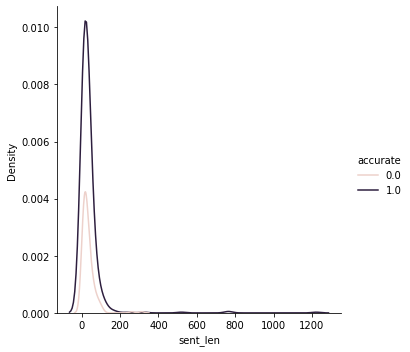

In [201]:
import seaborn as sns
sent_len = sns.displot(data=sent_db, x='sent_len',hue='accurate',kind='kde')

[(1.0, 100.0)]

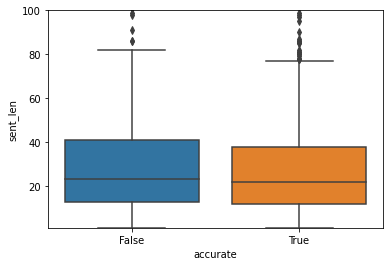

In [205]:
ax = sns.boxplot(x="accurate", y="sent_len", data=sent_db)
ax.set(ylim=(1,100))

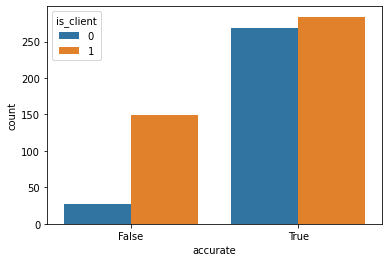

In [212]:
ax = sns.countplot(hue="is_client", x="accurate", data=sent_db)

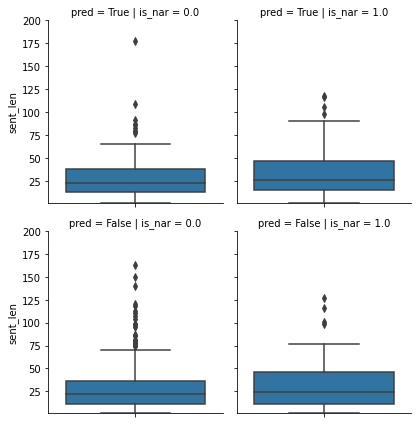

In [209]:
g = sns.FacetGrid(sent_db, col="is_nar",  row="pred")
g.map_dataframe(sns.boxplot, y="sent_len")
g.set(ylim=(1,200))

### Cross-validate

In [215]:
score_db = pd.DataFrame()

In [253]:
imp.reload(feature_utils)
shapes = [(3,3), # sequence [1:3][4:6]...
          (3,2), # sequence [1:3][3:7]...
          (3,1)] # sequence [1:3][2:4][3:5]...
n_groups = len(set(groups_plane))
test_percent = 0.40
n_splits = int(n_groups*test_percent)
n_out = int(n_groups/n_splits)
if n_out == 1:
    logo = LeaveOneGroupOut()
else:
#     logo = LeavePGroupsOut(n_groups=num_out)
    logo = GroupKFold(n_splits=n_splits)
    print(logo.get_n_splits(X_plane,y_plane,groups_plane))

for shape in shapes[:1]:
    seq_len = shape[0]
    step = shape[1]
    X_shaped,y_shaped,groups_shaped = feature_utils.reshape_doc_paragraphs_to_sequence(X_plane,y_plane,groups_plane,seq_len,step)
    score = feature_utils.leave_out_validate(X_shaped,y_shaped,groups_shaped,logo)
    feature_utils.add_score_to_db(score_db,"out{}_len{}_step{}".format(n_out,seq_len,step),score)

25
doc paragraphs reshaped: from 10515 to 3505
True labels 0.31 of train, 0.22 of test
True labels 0.31 of train, 0.24 of test
True labels 0.31 of train, 0.18 of test
True labels 0.31 of train, 0.27 of test
True labels 0.31 of train, 0.32 of test
True labels 0.30 of train, 0.67 of test
True labels 0.30 of train, 0.40 of test
True labels 0.31 of train, 0.34 of test
True labels 0.30 of train, 0.41 of test
True labels 0.31 of train, 0.10 of test
True labels 0.31 of train, 0.21 of test
True labels 0.30 of train, 0.38 of test
True labels 0.31 of train, 0.37 of test
True labels 0.30 of train, 0.41 of test
True labels 0.31 of train, 0.25 of test
True labels 0.32 of train, 0.18 of test
True labels 0.31 of train, 0.26 of test
True labels 0.31 of train, 0.35 of test
True labels 0.31 of train, 0.32 of test
True labels 0.31 of train, 0.34 of test
True labels 0.31 of train, 0.17 of test
True labels 0.31 of train, 0.26 of test
True labels 0.31 of train, 0.34 of test
True labels 0.31 of train, 0.21 o

In [233]:
score_db

,f1,recall,precision
out1_len3_step2,0.781527,0.788285,0.810018
out15_len3_step3,0.790064,0.794885,0.792726
out20_len3_step3,0.795388,0.800743,0.799100
out25_len3_step3,0.780852,0.787882,0.794047


### Run single example - sequence = 3x paragraph [1:3][2:4]...

In [254]:
X_shaped,y_shaped,groups_shaped= feature_utils.reshape_doc_paragraphs_to_sequence(X_plane,y_plane,groups_plane,3,2)

crf = CRF(
#     min_freq = 5,
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    )
n_groups = len(set(groups_plane))
test_percent = 0.33
n_out = int(n_groups*test_percent)
logo =  GroupKFold(n_splits=n_out)
print(logo.get_n_splits(X_plane,y_plane,groups_plane))
split = logo.split(X_shaped, y_shaped, groups_shaped)
itteration = 0
for train_idx, test_idx in split:
    if(itteration > 1):
        break
    itteration +=1
print("Train num: {}\nTest num: {}".format(len(train_idx),len(test_idx)))
X_train = itemgetter(*train_idx)(X_shaped)
y_train  = itemgetter(*train_idx)(y_shaped)
X_test = itemgetter(*test_idx)(X_shaped)
y_test = itemgetter(*test_idx)(y_shaped)

doc paragraphs reshaped: from 10515 to 5258
20
Train num: 5008
Test num: 250


In [255]:
crf.fit(X_train, y_train)
y_pred  =  crf.predict(X_test)
labels = list(crf.classes_)
f1 = metrics.flat_f1_score(y_test, y_pred,average='weighted', labels=labels)
recall = metrics.flat_recall_score(y_test, y_pred,average='weighted', labels=labels)
precision = metrics.flat_precision_score(y_test, y_pred,average='weighted', labels=labels)
print ("f1 {:.2f}\nrecall {:.2f}\nprecition {:.2f}".format(f1,recall,precision))

f1 0.79
recall 0.79
precition 0.79


              precision    recall  f1-score   support

       False       0.82      0.88      0.85      1227
        True       0.74      0.63      0.68       657

    accuracy                           0.79      1884
   macro avg       0.78      0.75      0.76      1884
weighted avg       0.79      0.79      0.79      1884



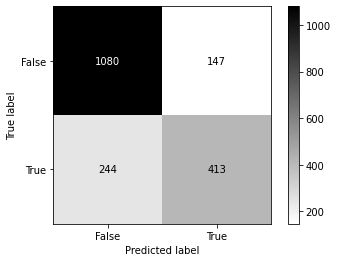

In [256]:
imp.reload(feature_utils)
labels = crf.classes_
feature_utils.get_prediction_report(flatten(y_test), flatten(y_pred),labels)